In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import pyro
import pyro.distributions as dist
import pyro.contrib.bnn as bnn
from pyro import infer
from pyro import optim
from pyro.distributions import constraints

from sklearn.datasets import make_moons
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

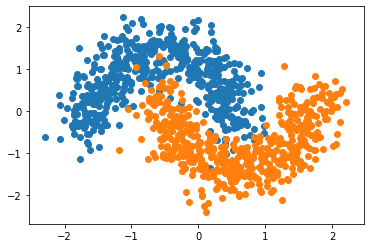

In [2]:
X, y = make_moons(noise=0.2, random_state=152, n_samples=1000)
X = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.show()

In [3]:
class BNN(nn.Module):
    """Bayesian neural network for binary classification
    """
    
    def __init__(self, X_train, y_train, n_hidden=10):
        super(BNN, self).__init__()
        assert X_train.size(0) == y_train.size(0)
        self.X_train = X_train.float()
        self.y_train = y_train.float().view(-1, 1)
        self.total_size = X_train.size(0)
        self.n_hidden = n_hidden
    
    def model(self, X, y=None):
        n_input = X.size(0)
        n_features = X.size(1)
        kl_factor = n_input / self.total_size
        # define standard normal priors on all weights
        a1_mean = torch.zeros(n_features, self.n_hidden)
        a1_scale = torch.ones(n_features, self.n_hidden)
        a2_mean = torch.zeros(self.n_hidden+1, self.n_hidden)
        a2_scale = torch.ones(self.n_hidden+1, self.n_hidden)
        a3_mean = torch.zeros(self.n_hidden+1, 1)
        a3_scale = torch.ones(self.n_hidden+1, 1)
        # make batches conditionally independent given params
        with pyro.plate('data', size=n_input):
            h1 = pyro.sample('h1', bnn.HiddenLayer(X, a1_mean, a1_scale, KL_factor=kl_factor))
            h2 = pyro.sample('h2', bnn.HiddenLayer(h1, a2_mean, a2_scale, KL_factor=kl_factor))
            h3 = pyro.sample('h3', bnn.HiddenLayer(h2, a3_mean, a3_scale, non_linearity=torch.sigmoid,
                                                   KL_factor=kl_factor, include_hidden_bias=False))
            return pyro.sample('out', dist.Bernoulli(probs=h3), obs=y)
        
    def guide(self, X, y=None):
        n_input = X.size(0)
        n_features = X.size(1)
        kl_factor = n_input / self.total_size
        # define initial values fo params, analagous to in model
        a1_mean = pyro.param('a1_mean', 0.01 * torch.randn(n_features, self.n_hidden))
        a1_scale = pyro.param('a1_scale', 0.1 * torch.ones(n_features, self.n_hidden),
                              constraint=constraints.positive).double()
        a2_mean = pyro.param('a2_mean', 0.01 * torch.randn(self.n_hidden+1, self.n_hidden))
        a2_scale = pyro.param('a2_scale', 0.1 * torch.ones(self.n_hidden+1, self.n_hidden),
                              constraint=constraints.positive).double()
        a3_mean = pyro.param('a3_mean', 0.01 * torch.randn(self.n_hidden+1, 1))
        a3_scale = pyro.param('a3_scale', 0.1 * torch.ones(self.n_hidden+1, 1),
                              constraint=constraints.positive)
        with pyro.plate('data', size=n_input):
            h1 = pyro.sample('h1', bnn.HiddenLayer(X, a1_mean, a1_scale, KL_factor=kl_factor)).float()
            h2 = pyro.sample('h2', bnn.HiddenLayer(h1, a2_mean, a2_scale, KL_factor=kl_factor)).float()
            h3 = pyro.sample('h3', bnn.HiddenLayer(h2, a3_mean, a3_scale, non_linearity=torch.sigmoid,
                                                   KL_factor=kl_factor, include_hidden_bias=False))

    def forward(self, X, n_samples=10):
        res = []
        for i in range(n_samples):
            trace = pyro.poutine.trace(self.guide).get_trace(X)
            res.append(trace.nodes['h3']['value'])
        return torch.stack(res, dim=0)
    
                
    def infer(self, lr=0.001, momentum=0.9, batch_size=32, num_epochs=100):
        optimizer = optim.SGD({'lr': lr, 'momentum': momentum, 'nesterov': True})
        elbo = infer.TraceMeanField_ELBO()
        svi = infer.SVI(self.model, self.guide, optimizer, elbo)
        for i in range(num_epochs):
            total_loss = 0
            total = 0
            correct = 0
            for j in np.arange(self.total_size, step=batch_size):
                X, y = self.X_train[j:j+batch_size], self.y_train[j:j+batch_size]
                loss = svi.step(X, y)
                pred = self.forward(X, n_samples=1).mean(axis=0)
                total_loss += loss / len(X_train)
                total += y.size(0)
                correct += ((pred > 0.5) == y).sum().item()
                param_store = pyro.get_param_store()
            print(f'Epoch {i+1}: loss = {total_loss:.5E}, accuracy = {correct / total:.5f}')


In [4]:
pyro.clear_param_store()
bayesian_nn = BNN(torch.from_numpy(X_train), torch.from_numpy(y_train), n_hidden=10)
bayesian_nn.infer(lr=1e-4, momentum=0.95, num_epochs=50)

Epoch 1: loss = 2.13321E+01, accuracy = 0.53800
Epoch 2: loss = 2.13515E+01, accuracy = 0.53600
Epoch 3: loss = 2.12556E+01, accuracy = 0.53600
Epoch 4: loss = 2.12866E+01, accuracy = 0.55400
Epoch 5: loss = 2.12776E+01, accuracy = 0.55200
Epoch 6: loss = 2.11692E+01, accuracy = 0.51800
Epoch 7: loss = 2.12211E+01, accuracy = 0.53800
Epoch 8: loss = 1.81041E+01, accuracy = 0.65400
Epoch 9: loss = 1.16423E+01, accuracy = 0.86000
Epoch 10: loss = 1.20088E+01, accuracy = 0.83600
Epoch 11: loss = 1.07675E+01, accuracy = 0.86400
Epoch 12: loss = 1.03436E+01, accuracy = 0.86000
Epoch 13: loss = 1.00238E+01, accuracy = 0.86000
Epoch 14: loss = 9.99857E+00, accuracy = 0.86000
Epoch 15: loss = 9.93609E+00, accuracy = 0.86000
Epoch 16: loss = 9.81256E+00, accuracy = 0.87000
Epoch 17: loss = 9.59253E+00, accuracy = 0.86400
Epoch 18: loss = 9.81092E+00, accuracy = 0.86400
Epoch 19: loss = 9.79085E+00, accuracy = 0.86400
Epoch 20: loss = 9.61101E+00, accuracy = 0.86800
Epoch 21: loss = 9.83682E+00,

In [5]:
with torch.no_grad():
    out = bayesian_nn.forward(torch.from_numpy(X_test).float())

In [6]:
pred = out.mean(axis=0) > 0.5
true = torch.from_numpy(y_test).float().view(-1,1)

In [7]:
# calculate accuracy on test data
(pred == true).sum().item() / len(true)

0.954

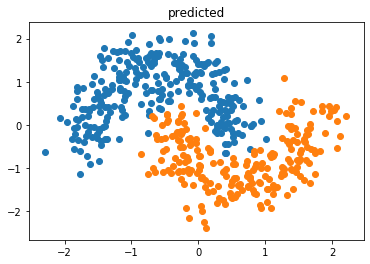

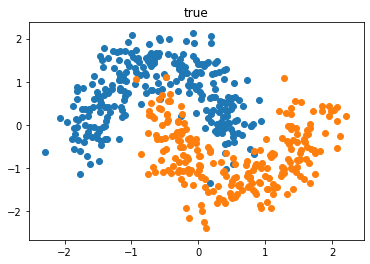

In [8]:
plt.scatter(X_test[~pred.flatten(), 0], X_test[~pred.flatten(), 1])
plt.scatter(X_test[pred.flatten(), 0], X_test[pred.flatten(), 1])
plt.title('predicted')
plt.show()

plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1])
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1])
plt.title('true')
plt.show()

In [9]:
with torch.no_grad():
    grid = np.mgrid[-3:3:100j, -3:3:100j]
    grid2d = torch.from_numpy(grid.reshape(2, -1).T).float()
    ppc = bayesian_nn.forward(grid2d, 100)

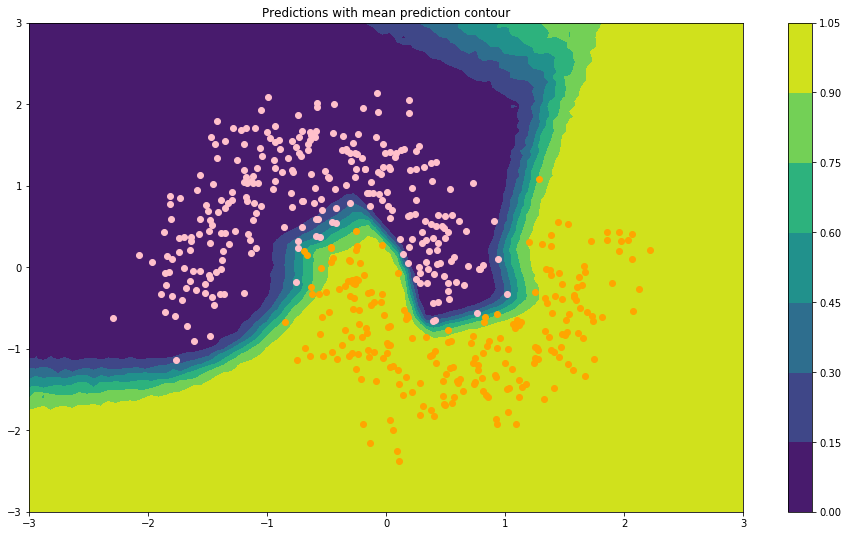

In [10]:
fig, ax = plt.subplots(figsize=(16,9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100))
ax.scatter(X_test[~pred.flatten(), 0], X_test[~pred.flatten(), 1], color='pink')
ax.scatter(X_test[pred.flatten(), 0], X_test[pred.flatten(), 1], color='orange')
plt.colorbar(contour, ax=ax)
plt.title('Predictions with mean prediction contour')
plt.show()

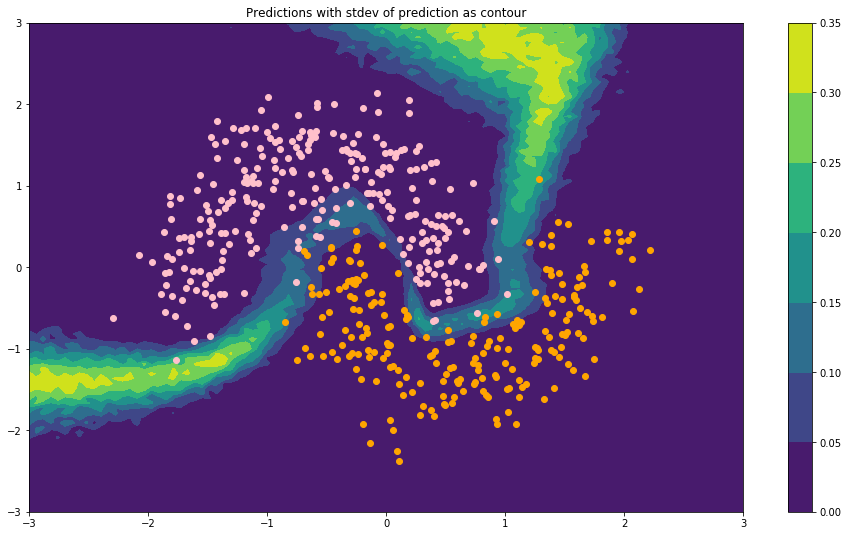

In [11]:
fig, ax = plt.subplots(figsize=(16,9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).view(100, 100))
ax.scatter(X_test[~pred.flatten(), 0], X_test[~pred.flatten(), 1], color='pink')
ax.scatter(X_test[pred.flatten(), 0], X_test[pred.flatten(), 1], color='orange')
plt.colorbar(contour, ax=ax)
plt.title('Predictions with stdev of prediction as contour')
plt.show()

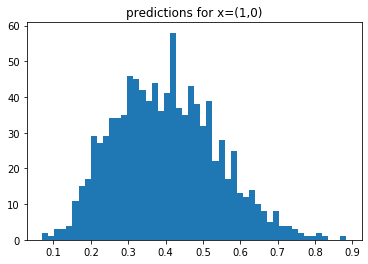

In [12]:
# show range of predictions for example value (1,0)

with torch.no_grad():
    x = torch.tensor([1, 0]).view(1, 2).float()
    prediction = bayesian_nn.forward(x, 1000)

plt.hist(prediction.flatten(), bins=50)
plt.title('predictions for x=(1,0)')
plt.show()
    